In [1]:
import datetime
import logging
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
import joblib
import tensorflow as tf
from tensorflow import keras
from keras.layers import Reshape, MaxPool3D, Bidirectional, ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Conv2D
from keras.layers import Dropout
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso
import pymongo
import random
import string
import fasttext
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tag import pos_tag
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

HOME = os.environ['LIMA_HOME']


2022-01-27 20:37:48.720183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 20:37:48.742499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 20:37:48.742672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def clean(text: str) -> list:
    """
    clean text with tokenization; stemming; removing stop word, punctuation, number, and empty string.

    Args:
        text (str): text

    Returns:
        list: cleaned text as list of tokenized str
    """

    # to list of token
    text = word_tokenize(text)

    # stemming and convert to lower case if not proper noun: punctuation and stop word seem to help POS tagging, remove them after stemming
    word_tag = pos_tag(text)
    porter = PorterStemmer()
    text = [
        porter.stem(each[0])
        if each[1] != "NNP" and each[1] != "NNPS" else each[0]
        for each in word_tag
    ]

    # remove stop word: it seems stemming skip stop word; OK to remove stop word after stemming;
    stop_word = set(stopwords.words('english'))
    text = [each for each in text if not each in stop_word]

    # remove punctuation
    text = [
        each.translate(str.maketrans('', '', string.punctuation))
        for each in text
    ]
    # text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text) # if using re

    # convert number to <NUM>
    text = ["<NUM>" if each.isdigit() else each for each in text]

    # remove empty string
    text = [each for each in text if each != ""]

    return text

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = data.copy()
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
        
		names += [f'{data.columns[j]}(t-{i})' for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [f'{data.columns[j]}(t)' for j in range(n_vars)]
		else:
			names += [f'{data.columns[j]}(t+{i})' for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def get_TS_cv(k=5, test_size=None):
    """
    ML models do not need to care about forecast horizon when splitting training and test set. Forecast horizon should be handled by feature preparation ([X_t-1,X_t-2...]). Actually repeated K-fold can also be used, but stick to TS split to align with TS_evaluate().
    """
    return TimeSeriesSplit(
        n_splits=k,
        gap=0,
        test_size=test_size,
    )

def evaluate_series(y_true, y_pred, horizon):
    """
    Some models (like ARIMA) may not support cross_validate(), compare the forecasting result directly
    Args:
        y_true: y of test set
        y_pred: y of prediction
        horizon: forecast horizon

    Returns:
        DataFrame: single row DF with 3 metrics wrt horizon
    """
    # RMSE
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2=r2_score(y_true, y_pred)
    forecast_error = {
        'h': horizon,
        'mae': [mae],
        'rmse': [rmse],
        'mape': [mape],
        'r2':[r2],
        'descriptions': ""
    }
    return forecast_error


In [3]:
# set random seed
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
h = 1
past = 5

# load metrics

In [4]:
from influxdb_client import InfluxDBClient
client= InfluxDBClient.from_config_file(f"{HOME}/dev/DB/influxdb_config.ini")
query_api = client.query_api()
df_WTI = query_api.query_data_frame("""
from(bucket: "dummy")
  |> range(start: 2011-04-01, stop: 2019-04-01)
  |> filter(fn: (r) => r["_measurement"] == "WTI") 
  |> filter(fn: (r) => r["type"] == "closing_price") 
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> drop(columns: ["_start", "_stop"])
""")
df_WTI=df_WTI[["_time","CLC4","CLC3","CLC2","CLC1"]]
df_WTI.columns=["Date","CLC4","CLC3","CLC2","CLC1"]
df_WTI.set_index("Date",inplace=True)
df_WTI.index=df_WTI.index.map(lambda each: each.date())
df_WTI.index=pd.to_datetime(df_WTI.index)
client.close()

In [5]:
month=[each.month for each in df_WTI.index]
day=[each.day for each in df_WTI.index]
day_in_week=[each.weekday() for each in df_WTI.index]
df_dt=pd.DataFrame()
df_dt["month"]=month
df_dt["day"]=day
df_dt["day_in_week"]=day_in_week
df_dt.index=df_WTI.index

In [6]:
df_WTI

,CLC4,CLC3,CLC2,CLC1
Date,,,,
2011-04-01,109.17,108.94,108.50,107.94
2011-04-04,109.83,109.53,109.05,108.47
2011-04-05,109.91,109.56,108.99,108.34
2011-04-06,110.39,110.05,109.48,108.83
2011-04-07,111.66,111.37,110.88,110.30
...,...,...,...,...
2019-03-25,59.55,59.33,59.08,58.82
2019-03-26,60.34,60.23,60.10,59.94
2019-03-27,59.91,59.77,59.61,59.41


# Text Features

In [7]:
fasttext_model = fasttext.load_model(f"{HOME}/data/big/cc.en.300.bin")

In [8]:
df_sentiment=pd.read_pickle("df_sentiment_2type.pkl")
df_sentiment.shape

(2014, 6)

In [9]:
df_topic=pd.read_pickle("df_topic_2type.pkl")
df_topic.shape

(2014, 10)

In [10]:
df_geoidx=pd.read_pickle("df_geoidx_2type.pkl")
df_geoidx.shape

(2014, 12)

In [11]:
df_Xy = pd.concat([df_sentiment,df_topic, df_geoidx,df_WTI["CLC1"]], axis=1, join="inner")
print(df_Xy.shape)
df_Xy.head(1)

(2014, 29)


,Polarity,Subjectivity,Combined_Sentiment,Decay_Polarity,Decay_Subjectivity,Decay_Combined_Sentiment,Topic1,Topic2,Topic3,Topic4,...,Terrorist_Threats,War_Acts,Terrorist_Acts,Decay_Geopolitical_Threats,Decay_Nuclear_Threats,Decay_War_Threats,Decay_Terrorist_Threats,Decay_War_Acts,Decay_Terrorist_Acts,CLC1
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-01,0.085833,0.3475,0.11566,0.085833,0.3475,0.11566,0.155508,0.119983,0.070445,0.500355,...,0.221318,0.35214,0.359889,0.32632,0.257284,0.242575,0.221318,0.35214,0.359889,107.94


In [12]:
df_shifted = series_to_supervised(df_Xy.dropna(), past, h)
# remove current day features for forecast
for each in df_shifted.columns[:-1]:
    if "(t)" in each:
        df_shifted.drop(each, axis=1, inplace=True)
# add time feature without shift 
df_shifted=pd.concat([df_dt,df_shifted],axis=1).dropna()
raw_X = df_shifted.to_numpy()[:, :-1]
y =  df_shifted.to_numpy()[:, -1].reshape(-1, 1) 
# y = df_Xy[df_Xy.index.isin(df_selected.index)].to_numpy()[:, -1].reshape(-1, 1)
# y=df_WTI[df_WTI.index.isin(df_selected.index)]["CLC1"].to_numpy().reshape(-1, 1)
f"{raw_X.shape}   |{y.shape} | "

'(2009, 148)   |(2009, 1) | '

# Feature Selection

In [13]:
from sklearn.feature_selection import mutual_info_regression,RFE,RFECV,SelectFromModel,SequentialFeatureSelector,chi2,SelectKBest,f_regression,VarianceThreshold,r_regression
from sklearn.linear_model import Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.svm import LinearSVR,SVR

In [27]:
estimator = Lasso(random_state=42)
selector = RFE(estimator,n_features_to_select=30,step=1)
scaled_raw_X=MinMaxScaler().fit_transform(raw_X)
selector = selector.fit(scaled_raw_X, y.ravel())

In [74]:
X = raw_X[:, selector.get_support()]
print(f"{X.shape} | {y.shape}")
df_shifted.columns[:-1][selector.get_support()]

(2009, 30) | (2009, 1)


Index(['Decay_Topic2(t-5)', 'Decay_Topic3(t-5)', 'Decay_Topic4(t-5)',
       'Decay_Topic5(t-5)', 'Geopolitical_Threats(t-5)',
       'Nuclear_Threats(t-5)', 'War_Threats(t-5)', 'Terrorist_Threats(t-5)',
       'War_Acts(t-5)', 'Terrorist_Acts (t-5)',
       'Decay_Geopolitical_Threats(t-5)', 'Decay_Nuclear_Threats(t-5)',
       'Decay_War_Threats(t-5)', 'Decay_Terrorist_Threats(t-5)',
       'Decay_Topic2(t-1)', 'Decay_Topic4(t-1)', 'Decay_Topic5(t-1)',
       'Geopolitical_Threats(t-1)', 'Nuclear_Threats(t-1)', 'War_Threats(t-1)',
       'Terrorist_Threats(t-1)', 'War_Acts(t-1)', 'Terrorist_Acts (t-1)',
       'Decay_Geopolitical_Threats(t-1)', 'Decay_Nuclear_Threats(t-1)',
       'Decay_War_Threats(t-1)', 'Decay_Terrorist_Threats(t-1)',
       'Decay_War_Acts(t-1)', 'Decay_Terrorist_Acts (t-1)', 'CLC1(t-1)'],
      dtype='object')

# Model

In [75]:
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, ARDRegression, SGDRegressor, ElasticNet, Lars, Lasso, GammaRegressor, TweedieRegressor, PoissonRegressor, Ridge, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from keras.layers import Reshape,MaxPooling2D,Bidirectional,ConvLSTM2D
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN 
from keras.layers import Conv2D,Conv3D
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Flatten
from keras.models import Model
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(seed_value)

In [76]:
length=X.shape[0]
train_size=int(length*0.7)
step_size=1

train_X=X[:train_size]
train_y=y[:train_size,:]

test_X=X[train_size:]
test_y=y[train_size:,:]

X_scaler = MinMaxScaler()
X_scaler.fit(train_X)
train_X=X_scaler.transform(train_X)
test_X=X_scaler.transform(test_X)

# train_X=train_X.reshape(train_X.shape[0],step_size,train_X.shape[-1])
# test_X=test_X.reshape(test_X.shape[0],step_size,test_X.shape[-1])
print(f"train_X: {train_X.shape}\t   \t test_X:{test_X.shape}")
print(f"train_y: {train_y.shape}\t   test_y:{test_y.shape}")

train_X: (1406, 30)	   	 test_X:(603, 30)
train_y: (1406, 1)	   test_y:(603, 1)


In [77]:
all_X=np.concatenate([train_X,test_X])
lin_model=LinearRegression()
lin_model.fit(train_X,train_y.ravel())
linear_y=lin_model.predict(all_X)

In [78]:
evaluate_series(y,linear_y,1)

{'h': 1,
 'mae': [1.0024480675820517],
 'rmse': [1.3216394888907417],
 'mape': [0.015384922471402796],
 'r2': [0.9968102216157455],
 'descriptions': ''}

In [82]:
non_linear_y=y-linear_y.reshape(y.shape)
non_linear_y.shape

(2009, 1)

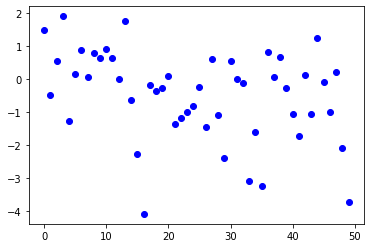

In [83]:
from matplotlib import pyplot as plt 
plt.plot(non_linear_y[250:300],'ob') 
plt.show()

In [84]:
train_non_linear_y=non_linear_y[:train_size,:]
test_non_linear_y=non_linear_y[train_size:,:]
f"{non_linear_y.shape}|{train_non_linear_y.shape}|{test_non_linear_y.shape}"

'(2009, 1)|(1406, 1)|(603, 1)'

In [85]:
non_linear_y_scaler = MinMaxScaler(feature_range=(1, 100))
non_linear_y_scaler.fit(train_non_linear_y)
train_non_linear_y=non_linear_y_scaler.transform(train_non_linear_y)
test_non_linear_y=non_linear_y_scaler.transform(test_non_linear_y)
f"{train_non_linear_y.shape}|{test_non_linear_y.shape}"

'(1406, 1)|(603, 1)'

In [102]:
# tf.keras.backend.clear_session()
ts_inputs = Input(shape=(train_X.shape[-1],))
ts_model=Reshape((step_size,train_X.shape[-1]))(ts_inputs)
ts_model=LSTM(50,dropout=0.8 ,return_sequences=True)(ts_model)
ts_model= Dropout(0.8)(ts_model)
ts_model=LSTM(50,dropout=0.8 ,return_sequences=True)(ts_model)
ts_model= Dropout(0.8)(ts_model)
ts_model=LSTM(50,dropout=0.8 ,return_sequences=True)(ts_model)
ts_model= Dropout(0.8)(ts_model)
ts_model=LSTM(50,dropout=0.8 ,return_sequences=False)(ts_model)
ts_model= Dropout(0.8)(ts_model)
# ts_model= Dropout(0.4)(ts_model)
# ts_model=Bidirectional(GRU(300,dropout=0.2 ,return_sequences=True))(ts_model)
# ts_model= Dropout(0.4)(ts_model)
# ts_model=Bidirectional(GRU(300,dropout=0.2 ,return_sequences=True))(ts_model)
# ts_model= Dropout(0.4)(ts_model)
# ts_model=Bidirectional(LSTM(300,dropout=0.4 ,return_sequences=False))(ts_model)
ts_model =Dense(1)(ts_model)
ts_model = Model(inputs=ts_inputs, outputs=ts_model)
# ts_model.compile(loss='mae', optimizer=Adam())
ts_model.compile(loss='log_cosh', optimizer=Adam(0.0002))
# ts_model.summary()

Epoch 1/300
36/36 [==============================] - 4s 31ms/step - loss: 56.8001 - val_loss: 59.0689
Epoch 2/300
36/36 [==============================] - 0s 4ms/step - loss: 56.7782 - val_loss: 59.0475
Epoch 3/300
36/36 [==============================] - 0s 4ms/step - loss: 56.7573 - val_loss: 59.0254
Epoch 4/300
36/36 [==============================] - 0s 4ms/step - loss: 56.7307 - val_loss: 59.0026
Epoch 5/300
36/36 [==============================] - 0s 4ms/step - loss: 56.7121 - val_loss: 58.9786
Epoch 6/300
36/36 [==============================] - 0s 4ms/step - loss: 56.6813 - val_loss: 58.9528
Epoch 7/300
36/36 [==============================] - 0s 4ms/step - loss: 56.6578 - val_loss: 58.9248
Epoch 8/300
36/36 [==============================] - 0s 4ms/step - loss: 56.6254 - val_loss: 58.8946
Epoch 9/300
36/36 [==============================] - 0s 4ms/step - loss: 56.5933 - val_loss: 58.8616
Epoch 10/300
36/36 [==============================] - 0s 4ms/step - loss: 56.5565 - val_lo

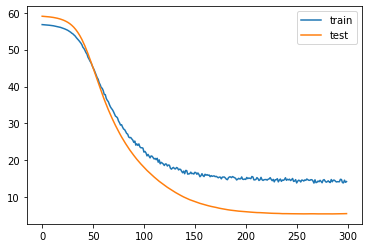

In [103]:
df_forecast_error = pd.DataFrame(
        columns=['h', 'mae', 'rmse', 'mape', 'descriptions'])
history = ts_model.fit(train_X, train_non_linear_y, epochs=300, batch_size=40, validation_data=(test_X, test_non_linear_y), verbose=1, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [104]:
pred_non_linear_y = ts_model.predict(test_X)
pred_non_linear_y.shape

(603, 1)

In [105]:
inverted_pred_non_linear_y = non_linear_y_scaler.inverse_transform(pred_non_linear_y.reshape(test_non_linear_y.shape))
inverted_test_non_linear_y = non_linear_y_scaler.inverse_transform(test_non_linear_y)
test_linear_y=linear_y[train_size:].reshape(-1,1)
inverted_pred_non_linear_y=inverted_pred_non_linear_y+test_linear_y
inverted_test_non_linear_y=inverted_test_non_linear_y+test_linear_y

evaluate_series(test_y, inverted_pred_non_linear_y, h)

{'h': 1,
 'mae': [0.9465669357972669],
 'rmse': [1.1664253154095656],
 'mape': [0.01656308383543575],
 'r2': [0.9812303339118221],
 'descriptions': ''}

In [56]:
evaluate_series(test_y, inverted_test_non_linear_y, h)

{'h': 1,
 'mae': [0.0],
 'rmse': [0.0],
 'mape': [0.0],
 'r2': [1.0],
 'descriptions': ''}